<a href="https://colab.research.google.com/github/HagarIbrahiem/APIStram_Countries_Cities/blob/master/Build_Conversational_AI_Memory_with_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What exactly is LangGraph?

At its core, Lang graph is a framework that helps you build stateful, multi-step applications powered by language models like OpenAI's GPTs or Anthropics loud.

LangGraph lets you build flows like conversations or processes that involve decisions, memory, and even loops, all using a graph-based structure.

Imagine each step in a conversation as a node you can connect logically like a map. The result, an agent that doesn't just respond, it thinks, remembers, and acts.

If you've ever built a basic chatbot, you've probably noticed a standard limitation. It doesn't remember what you just said two messages ago. That's because language models are `stateless`. They don't have built-in memory to retain past interactions.

This can be inconvenient, especially when we expect our bots to engage in meaningful, coherent conversations.

LangGraph addresses this limitation by giving us a way to manage what's called the graphs state. In simple terms, a graph's state is a bundle of information that travels from one node to the next, updating along the way.

This state can store previous user inputs, tool outputs, and relevant external data, allowing our chatbot to stay context aware and make intelligent decisions as the conversation unfolds. And that's exactly what we'll be learning to build on this course.


The key building blocks:

- States, which hold your data as it flows through the system.

- Nodes, which perform operations or decisions.

- Edges, which connect those nodes and determine the path forward.

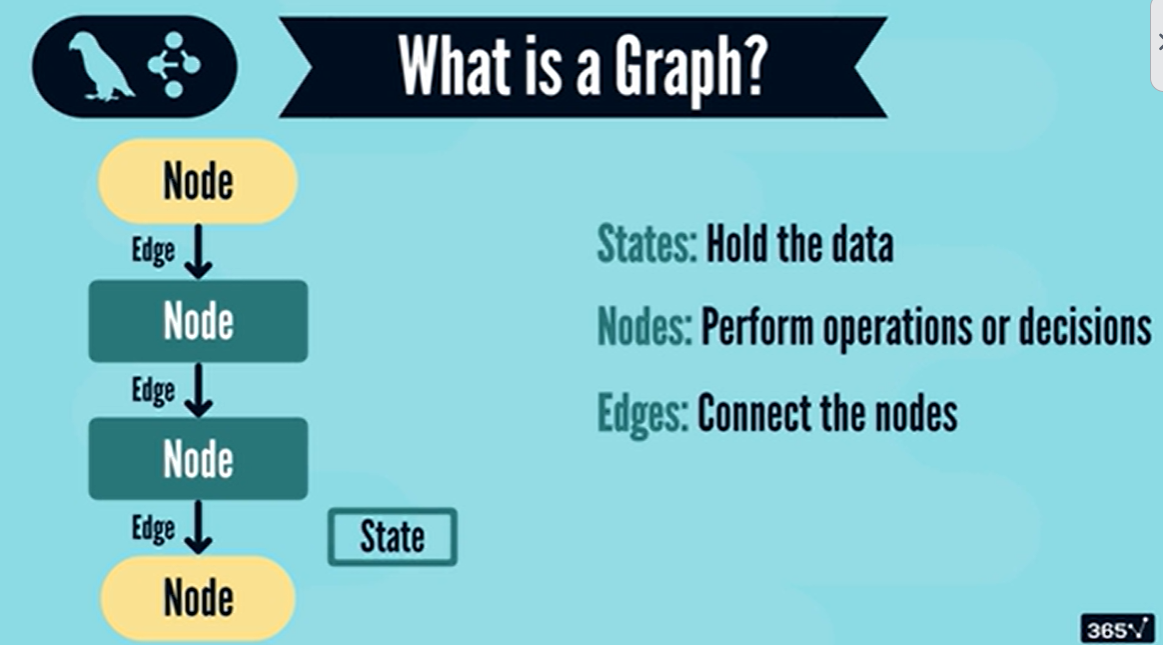

We'll focus on `conversation management`, a key piece of any chatbot. This part is crucial for building chatbots that feel smart and efficient, not forgetful or bloated.

**First**, you'll learn how to append user and assistant messages to a list as the conversation progresses. Then you'll explore how to truncate older messages, trimming the conversation to avoid memory overload.

But here's the challenge. When we trim messages, we risk losing important context. That's where `message summarization` comes in. You'll learn to summarize earlier parts of a conversation, replace long message histories with compact summaries, and maintain conversational coherence without wasting tokens.

With conversations flowing, we'll turn to memory management so your chatbot doesn't just react, but remembers.

We'll go through:

- Implementing short-term memory, persisting context between graph runs.

- Enabling long-term memory by storing data externally, like in a database or file, and retrieving it when needed.

These techniques let your chatbot evolve, remembering who the user is, past topics, and previous goals.

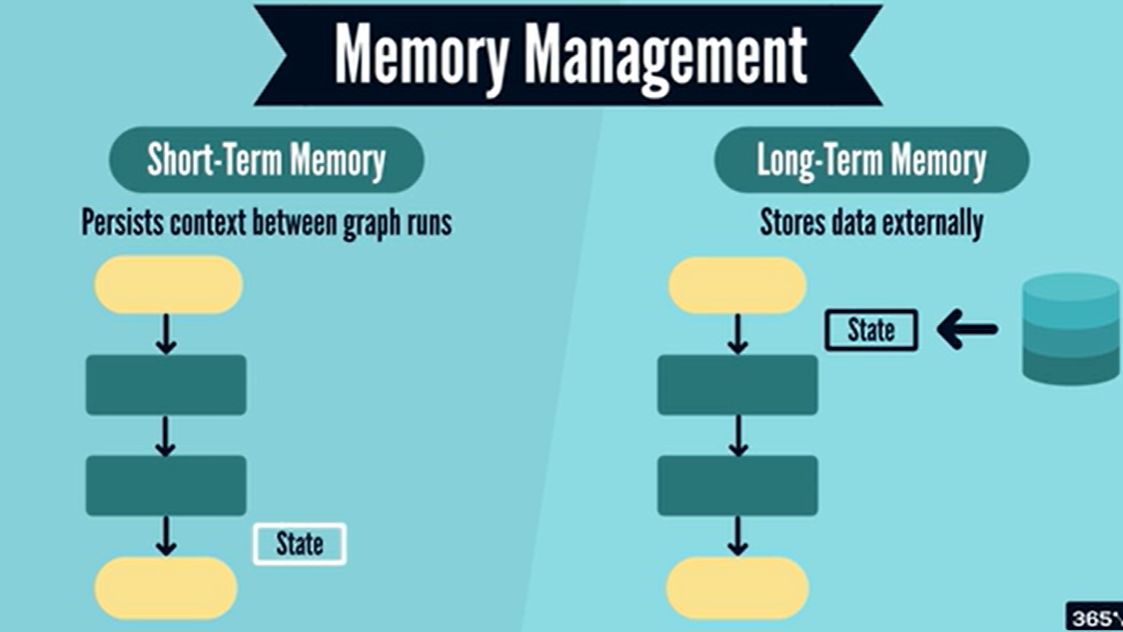

Let's start !

In [ ]:
# !pip install langchain
# !pip install langgraph
# !pip install langchain_openai
# !pip install langgraph-checkpoint-sqlite
# !pip install python-dotenv
# !pip install mypy-ipython
# !pip install grandalf
# !pip install ipykernel


In [ ]:
# !python -m ipykernel insall --user --name=langgraph-kernel

So, what exactly is a graph in langGraph?

At its core, a `graph` defines an application's flow. It's a structured map of how information moves and how tasks are executed.

- The first essential component of a graph is its `nodes`. Nodes are user-defined Python functions that each perform a specific task in the overall process.

Two special nodes always exist: the `start` and the `end` nodes, which mark where the graph begins and ends. The rest of the nodes are created by the developer to perform meaningful steps.

- The second essential component is the graph's `edges`. Edges define how data flows from one node to the next.

In our example, the flow might look like this:

* Start node → Greeting node
* Greeting node → LLM answer node
* LLM answer node → Summarization node
* Summarization node → End node

In line graph, edges aren't just abstract connections. They are represented by Python logic that **decides which node to visit next, depending on the current state.**

In simple cases, the flow is linear. Each node points directly to the next, forming a straight path from start to finish. But we can be more flexible than that.

Let's extend our example a little further.

Suppose that after summarizing the conversation, the last node in the graph asks the employee, do you need further assistance?

If Anna responds with, yes, the flow must loop back to the second node where the process repeats. If not, the graph proceeds to the end node.

This is done using `conditional edges`, which route the flow differently based on some value in the state, like a user's yes or no response. This branching logic allows for dynamic adaptable applications, exactly what we'll be creating together later in the course.

**Now, let's talk about the data that flows from node to node.**

langGraph uses a concept called `state` to represent the shared and updated data as the graph progresses. This state might contain users' input, the assistant's response, a running conversation history, retrieved documents, or tool outputs.

But this data needs structure, and that's where schemas come in. The schema defines what fields are expected in the state, what types they should be, and which are optional.

You can define it as a `Python dictionary`, specifically a typed dictionary, which we'll later use, or a `pydantic model`.

Think of it this way. **The state** is the actual data flowing through your land graph during execution, while **the schema** is the structure and rules that define what that state should look like.

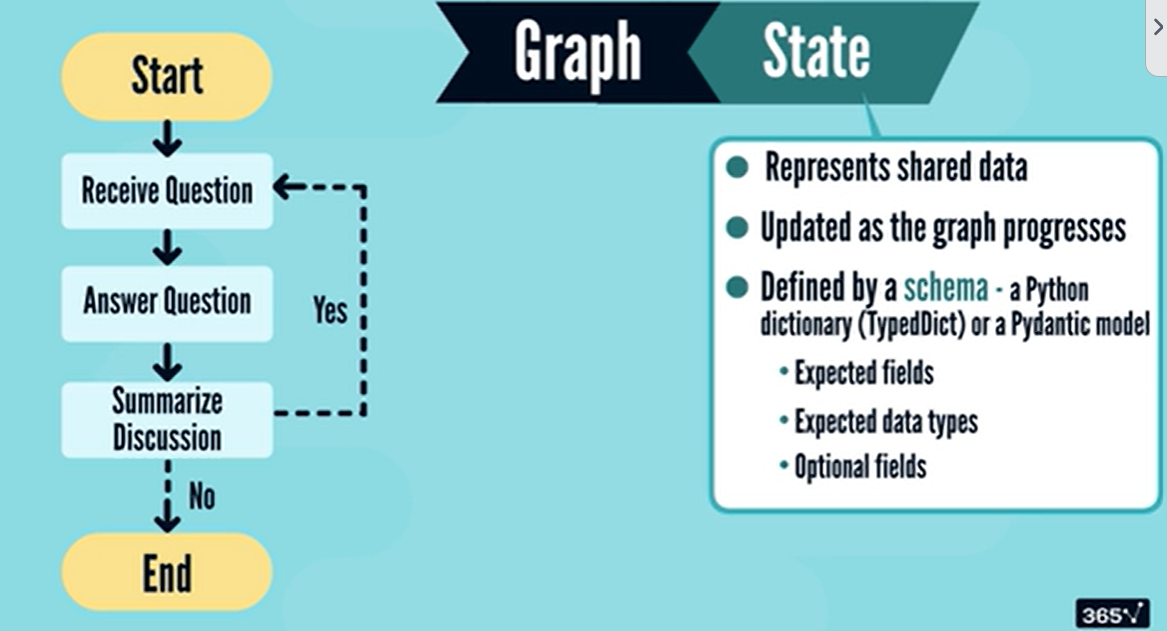


Before we wrap it up, there's one more important concept to introduce.

Consider a slightly more complex graph. You'll notice that some nodes are **horizontally** aligned on the same level. In line graph, this level is known as a super step.

**A super step** represents a single tick of the graph, where multiple nodes can be evaluated and executed in `parallel`. Nodes from different super steps are evaluated in sequence, moving forward step by step.

But just because nodes share a super step doesn't mean they all execute simultaneously. **A node only becomes active if it receives an input state**, and whether it does is determined by the edges leading into it.

So, in any given super step:
- only the nodes connected by incoming edges from the previous step,
- and whose conditions are met, will run.



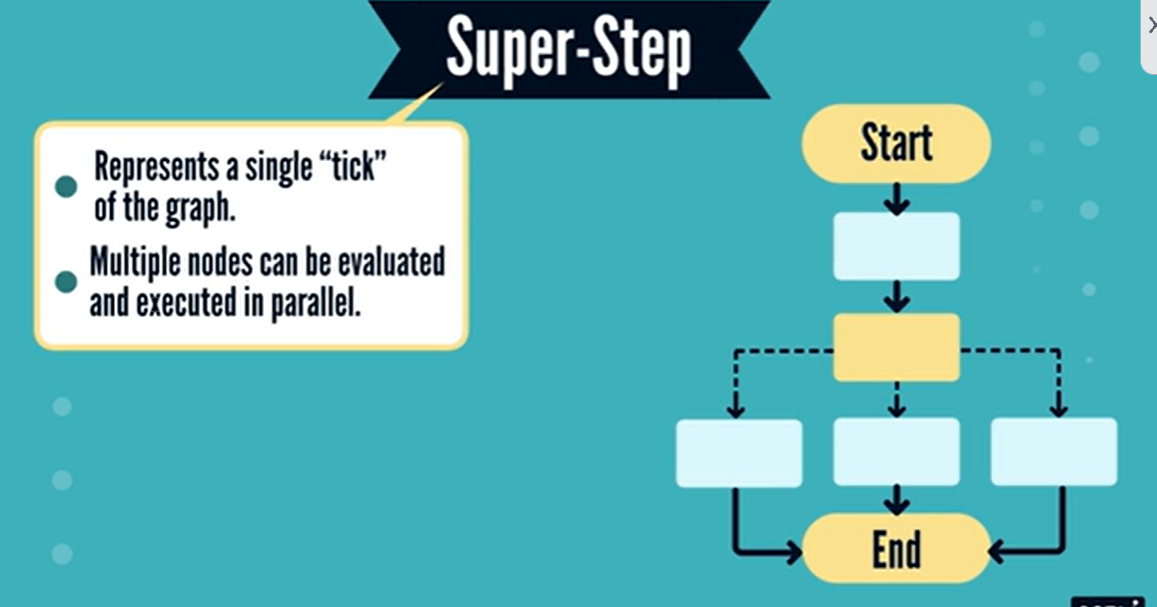

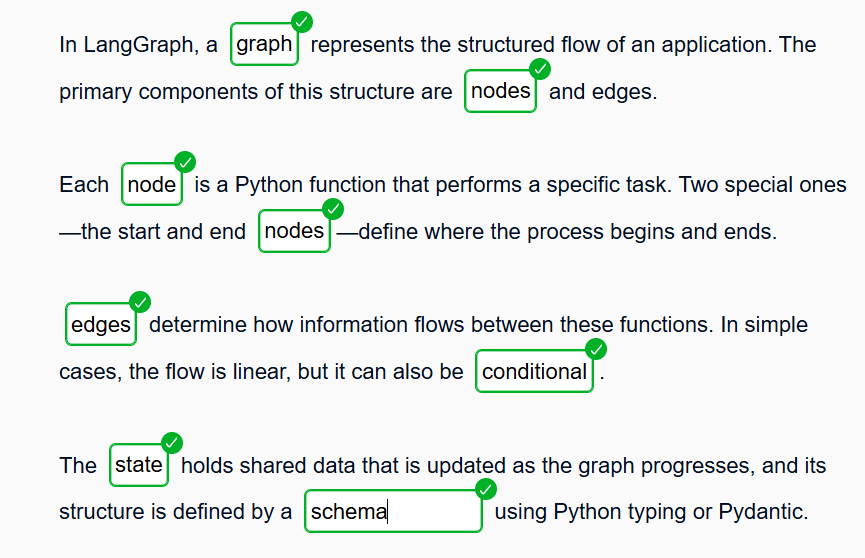

##Set the OpenAI API Key as an Environment Variable

In [ ]:

MISTRAL_API_key="Wl3MYXdt0YmeAx0wq0yPNYZp4fvb5cEE"

## Import Relevant Classes and Functions

In [ ]:
from langgraph.graph import START, END, StateGraph  #StateGraph will be our graph
START, END

('__start__', '__end__')

In [ ]:
from typing_extensions import TypedDict #Typed dictionaries are the most used objects for defining the schema of the graph.
#If you're already familiar with Python's type hints, you'll find typed dictionaries quite intuitive.
#In short, they let us define dictionaries with explicitly declared keys. If you try to populate the dictionary with an unexpected key, the type checker will flag it.
#Like other type hints though, this isn't enforced at runtime.


In [ ]:
from langchain_openai.chat_models import ChatOpenAI #import Lang Chain's chat open AI class, which allows for connecting with and using OpenAI's models.


ModuleNotFoundError: No module named 'langchain_openai'

In [ ]:
from langchain_core.messages import HumanMessage, BaseMessage # We'll use the HumanMessage to invoke a model with a human message, while the latter will be used for type checking.

In [ ]:
from langchain_core.runnables import Runnable
from collections.abc import Sequence # used for type hinting.

## Define the state
We begin by defining the state of the graph, which will be passed from node to node and updated along the way.
To do this, we'll create a new class, let's call it state, which inherits from the typed dictionary class.

This custom dictionary will contain a single key, messages, which will hold a sequence of items. More specifically, it will be a sequence of base message objects, human and AI messages.

The part of the code that comes after the colon is a type hint, specifying the expected data type for the value associated with the messages key.

Let's now create an object called state as an instance of this new class. Set the messages parameter to a list containing a single human message.

In [ ]:
class State (TypedDict):
  messages: Sequence [BaseMessage]

In [ ]:
state =State (messages=[HumanMessage("Could you tell me a grok by Piet Hein")])

In [ ]:
state

In [ ]:
state["messages"][0].pretty_print()

## Define the Node

In [ ]:
import getpass
import os

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [ ]:
chat = ChatOpenAI ( model = "gpt-4o", temperature=0 , seed= 365 ,   max_completion_tokens=100)

In [ ]:
reponse = chat.invoke(state['messages'])

In [ ]:
reponse

In [ ]:
reponse.pretty_print()

In [ ]:
#let's define a function serving as the brain of the node. Call it chatbot. Let it take the state of the graph as an argument of type state and return a new state object.

def chatbot (state:State) -> State: #This is type hinted using a colon and an arrow
  print(f"\n-----------> Entering Chatbot Node:") #This type of print statement will become especially useful as the number of nodes increases.
  reponse = chat.invoke(state['messages'])
  reponse.pretty_print()
  return State(messages=[response])



In [ ]:
chatbot(state)

We are approaching the finish line of creating our first graph. We have all the necessary components the state. The starting and ending nodes. And the node in the middle, a Python function responding to user messages.

## Define the components
To combine these components, we must first create an instance of the state graph class. A state graph is a graph whose nodes communicate by reading and writing to a shared state.

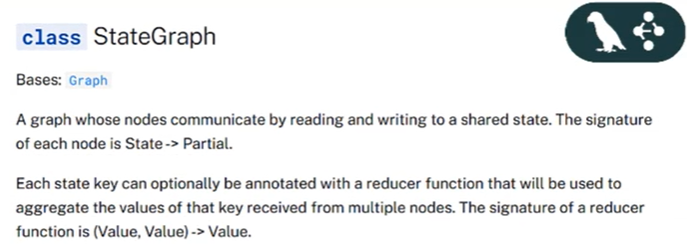

Let's define an instance of this class and call it graph. As a positional argument, pass the schema class that defines the state. In our case, that's the state class defined earlier.

In [ ]:
graph = StateGraph(State) # All nodes in the graph will expect a schema of this construction "state"

In [ ]:
# Now that we have the object, let's add the chatbot node to it.
# passing two positional arguments. The name of the node as a string and the chatbot function.
#If the first argument is not specified, the node's name becomes the name of the function.
graph.add_node("chatbot", chatbot)

Next, let's add edges connecting the three nodes. Connect the starting node with the chatbot node by passing the names of the two nodes as arguments. Then connect the chatbot node to the end node in the same fashion.

In [ ]:
graph.add_edge(START , chatbot)
graph.add_edge(chatbot , END)

There's one more step we must take before using the graph, and that is compiling the graph. This necessary step:
-  performs checks to ensure the graph is connected correctly.
- Additionally, it converts our state graph into a compiled state graph, a runable object.

In [ ]:
graph_compiled = graph.compile()

Running the cell, we see that the graph is an instance of the runnable class. Similarly, you can show that the graph object is not a runnable.

In [ ]:
isinstance(graph_compiled , Runnable)

In [ ]:
isinstance(graph , Runnable)

To got a diagram of the graph

In [ ]:
graph_compiled

## Test the Graph

In [ ]:
graph_compiled.invoke(state)

- First, we implemented a class inherited from the typed `dictionary class` that defined our `schema`.

- Second, we defined a `graph node` as a `Python function` that updates the value of the message key with a model's response.

- Third, we `constructed the graph` by adding the chatbot node and connecting it to the start and end nodes.

- Fourth, we `compiled` the graph, a process that checks whether the graph is connected correctly and produces a runnable object that can be invoked and easily visualized.

- The 5th and final step `invoked` the compiled graph with the state defined earlier.


- Finally, as promised, let's check the type hinting


In [ ]:
%mypy

For the `type check` to work correctly, the notebook cells must be executed in the correct order. Otherwise, the checker may not have access to the full context, which could raise avoidable errors.

Even if `mypy` happens to flag an error, don’t worry. Its messages are usually clear and helpful. These errors won’t stop your code from running, but they highlight possible mismatches between your type annotations and the actual values being passed around.

Think of them as helpful nudges to keep your code consistent and predictable.


# 2- Conditional Edges

Let’s now complicate things slightly by introducing two more nodes and a condition.

- We’ll add a new node after the starting one, prompting the user to ask their question. This will update the state with a `human message` storing the question.

- This state is then passed to the chatbot node, where it’s updated to store an `AI message` corresponding to the model’s response.

- The updated state is then fed to a third node located right before the ending one. It will be responsible for asking the user whether they want to ask one more question.

If `yes`, they will return to the second node and be prompted again. Otherwise, the graph terminates.


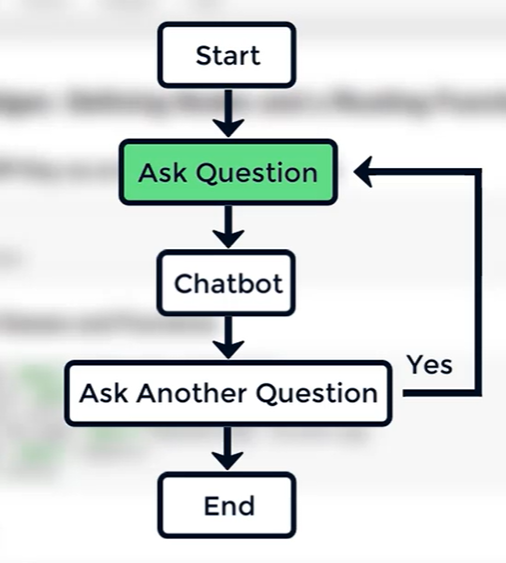

In [ ]:
from typing import Literal


This type hint is used to specify the exact values a variable can take. For instance, if a variable A is defined with the type literal [1,3,5], it means that a can only hold one of the values 1,3, or 5.

Of course, remember that this is a static type hint. Python won't enforce it at runtime, but type checkers can use it to catch incorrect assignments.

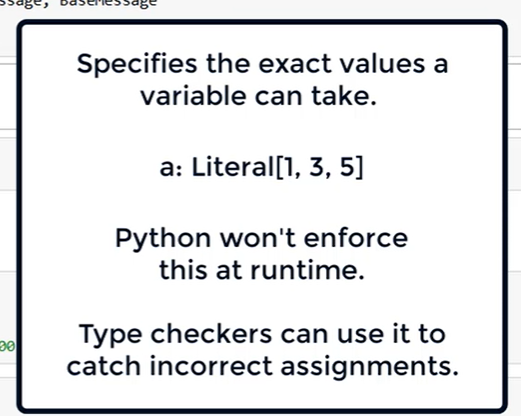

In [ ]:
#Define the State
class State(TypedDict):
    messages: Sequence[BaseMessage]

In [ ]:
#Define the Nodes
chat = ChatOpenAI(model = "gpt-4o",
                  seed = 365,
                  temperature = 0,
                  max_completion_tokens = 100)

In [ ]:
# Node 1
def ask_question(state: State) -> State:

    print(f"\n-------> ENTERING ask_question:")

    print("What is your question?")

    return State(messages = [HumanMessage(input())])

In [ ]:
ask_question(State(messages = []))

In [ ]:
# Node 2
def chatbot(state: State) -> State:

    print(f"\n-------> ENTERING chatbot:")

    response = chat.invoke(state["messages"])
    response.pretty_print()

    return State(messages = [response])

In [ ]:
# Node 3
def ask_another_question(state: State) -> State:

    print(f"\n-------> ENTERING ask_another_question:")

    print("Would you like to ask one more question (yes/no)?")

    return State(messages = [HumanMessage(input())])

In [ ]:
ask_another_question(State(messages = []))

In [ ]:
#Define the Routing Function
def routing_function(state: State) -> str:

    if state["messages"].content == "yes":
        return "ask_question"
    else:
        return "__end__"

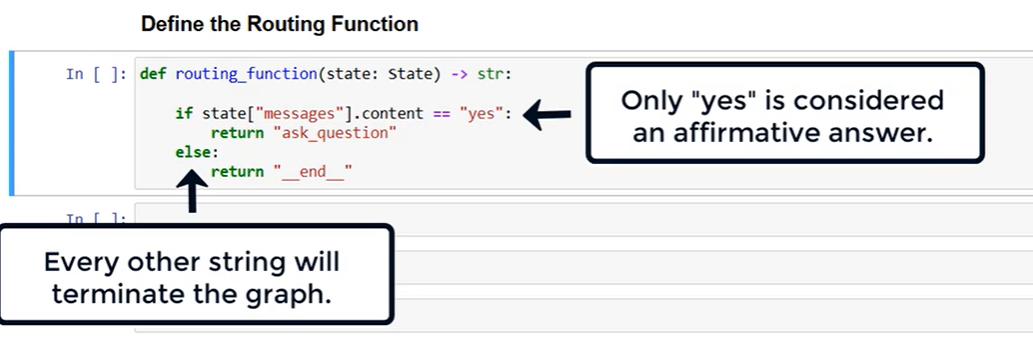

All right, we have all the components to create our graph, the 3 nodes and the routing function.


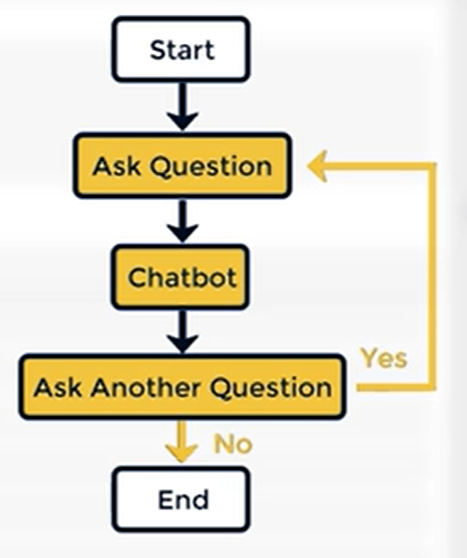

In [ ]:
### Define the graph
#Create an instance of the state graph class in the known fashion.
graph = StateGraph(State)

In [ ]:
# add the nodes to the graph.
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)

In [ ]:
# add the edges to the graph.
graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question",
                            path = routing_function)

This **last node** can lead to one of two nodes, ask question or the end node. To implement this logic, we require a different method, `add conditional edges`. The first required keyword argument, **source**, asks for the `origin node`.

In our case, that's `ask another question`. The second required keyword argument is `path`. This is **the callable** that determines the next node or nodes. For us, that's the routing function

In [ ]:
graph_compiled = graph.compile()

In [ ]:
graph_compiled

Hm, something doesn't seem right. The visualization doesn't accurately represent our logic, does it? There's no branching happening after the ask another question node. But there is a way to remedy this visualization problem. We have two alternatives.

 **First** : go several cells back to the add conditional edges method. Include one more keyword argument called Path map. This represents a dictionary that provides mapping for possible routes. In our case, the outcome true should be mapped to the ask question node and the outcome false to end.

In [ ]:
# add the edges to the graph.
graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question",
                            path = routing_function,
                            path_map= {"True" : "ask_question" , "False" : "__end__"})

graph_compiled = graph.compile()
graph_compiled


**Second**: Return to the routing function and note the type hint we used for the return value, a `string`. This string, however, is said to be only one of two values, ask question or end. This is a perfect candidate for the `literal` class we imported earlier. Recall that literal allowed us to indicate that a variable can take on only specific values.

In [ ]:
#Define the Routing Function
def routing_function(state: State) -> Literal["ask_question","__end__"]:

    if state["messages"].content == "yes":
        return "ask_question"
    else:
        return "__end__"


# add the edges to the graph.
graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question",
                            path = routing_function )

graph_compiled = graph.compile()
graph_compiled



Alternatively, you can use the draw Asy method to generate the graphs. If you're a fan of Asky art, you'll enjoy this option.

In [ ]:
print(graph_compiled.get_graph().draw_ascii())

In [ ]:
# test the Graph
graph_compiled.invoke(State(messages = []))

U can notice that The chatbot hasn't retained the memory of our previous correspondents. So, **how do we store interaction messages within the grap**h? That will be the topic of our next section.

In [ ]:
%mypy

# Message Managment

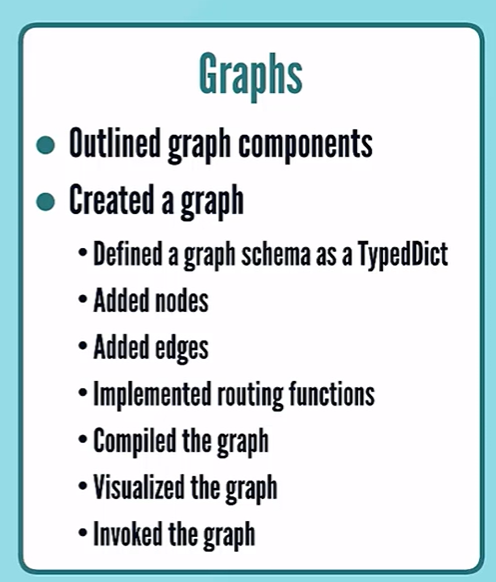

All went well until we realized our graph didn't `retain messages across the nodes`. As you've observed in previous lessons, updating a state in a graph happens by erasing the content previously stored under the messages key and substituting it with the new value. This is the default behavior of the graph. We'll now initiate the discussion of graph memory, starting with a simple concept, a pending new messages during state updates rather than substituting old ones.

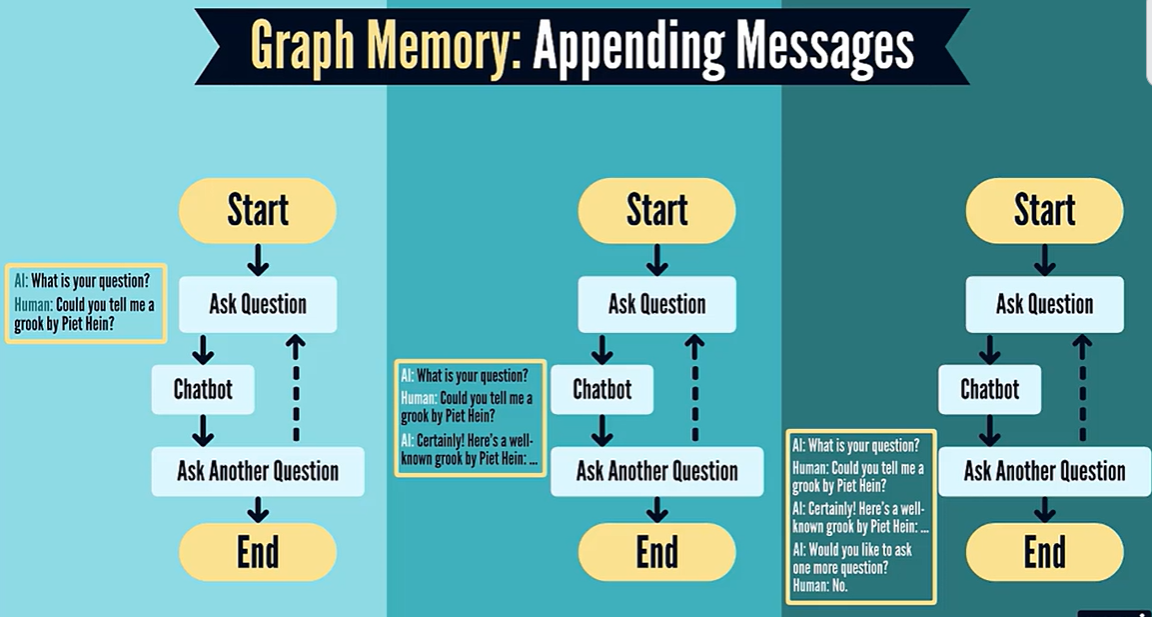

We'll do this elegantly using:
-  a special `line graph function`
-  and the annotated typing construct

using the same example, a chatbot represented as a graph with 5 nodes, 3 edges, and 1 conditional edge.

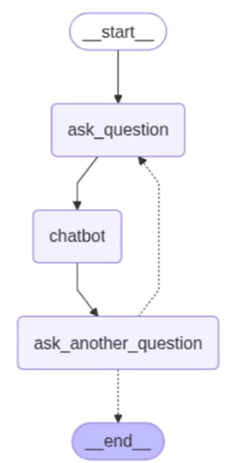

In [ ]:
from langgraph.graph import  add_messages
from langchain_core.messages import AIMessage
from typing import Annotated


Define an object called `my list` and set it equal to `add_messages`. The function requires two parameters:
- The first one corresponds to an initial list of messages.
- The second one, in turn, represents the list of messages that must be appended.

Let's tets it our !

In [ ]:
my_list = add_messages([HumanMessage("Hi! I'm Oscar."),
                        AIMessage("Hey, Oscar. How can I assist you?")],
                       [HumanMessage("Could you summarize today's news?")])

In [ ]:
#We find a list containing 3 lang chain messages
my_list

The next step is to modify the state class to override the default behavior of replacing state values after each node. Instead, we want to append updates to the existing state. We accomplished this with a small but significant change to the typeht.

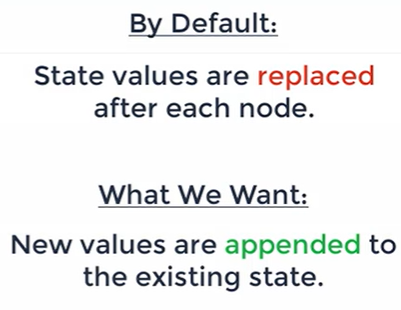

The messages field is no longer just typed as a sequence of base message objects. It's now wrapped in the `annotated type`. Annotated lets you attach metadata to a type. In this case, a sequence of messages.

For instance, imagine defining a variable for age and setting its type to an integer. While technically valid for an integer, it wouldn't make sense for age to be negative or greater than, say, 120. Using annotated, we could type hint at this constraint like so. Must be between 0 and 120. The variable is still an integer, but now it carries additional context that a validation tool or framework could use.

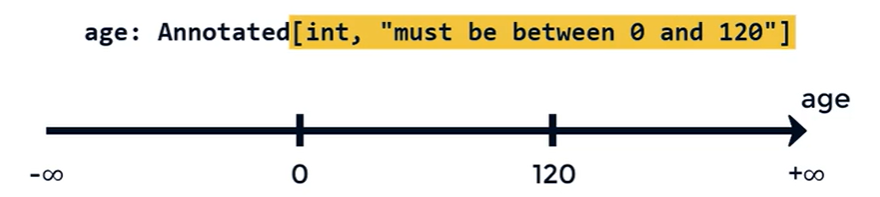

In [ ]:
# Define the State
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

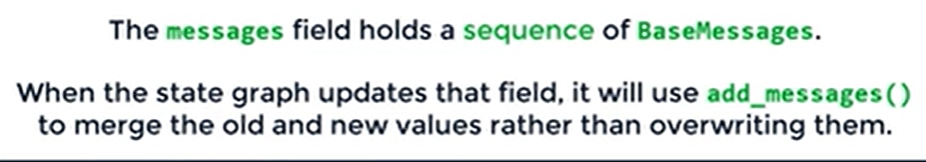

The `add_messages` function is what's known as a reducer function. A reducer defines how to combine the current state with new incoming data in a structured way.

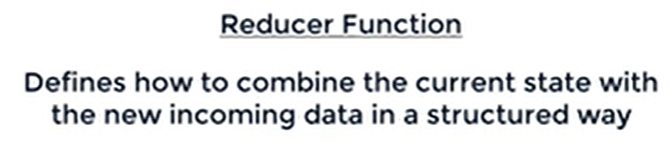

In [ ]:
# Define the Nodes
chat = ChatOpenAI(model = "gpt-4o",
                  seed = 365,
                  temperature = 0,
                  max_completion_tokens = 100)

In [ ]:
def ask_question(state: State) -> State:

    print(f"\n-------> ENTERING ask_question:")
    for i in state["messages"]: # 1- include a for loop that iterates through the list of messages and pretty prints them.
        i.pretty_print()

    question = "What is your question?" # 2- store what is your question in a variable named accordingly and display it on
    print(question)

    return State(messages = [AIMessage(question), HumanMessage(input())]) # 3- return an instance of the stage class with the messages parameter set equal to a list storing an AI message and a human message.
    # The "AIMessage" keeps the question to the user, and the "HumanMessage" keeps the user's response.

In [ ]:
def chatbot(state: State) -> State:

    print(f"\n-------> ENTERING chatbot:")

    response = chat.invoke(state["messages"])
    response.pretty_print()

    return State(messages = [response])

In [ ]:
#The third function, "ask_another_question", is modified similarly to the 1st fun.

def ask_another_question(state: State) -> State:

    print(f"\n-------> ENTERING ask_another_question:")
    for i in state["messages"]:
        i.pretty_print()

    question = "Would you like to ask one more question (yes/no)?"
    print(question)

    return State(messages = [AIMessage(question), HumanMessage(input())])

Now, the routing function must undergo slight modification as well. We expect to append each new message to the list, so we shouldn't be checking the first message, but the last one instead. This is modified easily by changing the index from 0 to -1.

In [ ]:
#Define the Routing Function
def routing_function(state: State) -> Literal["ask_question", "__end__"]:

    if state["messages"][-1].content == "yes":
        return "ask_question"
    else:
        return "__end__"

In [ ]:
#Define the Graph
graph = StateGraph(State)

In [ ]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question",
                            path = routing_function)

In [ ]:
graph_compiled = graph.compile()

In [ ]:
graph_compiled

In [ ]:
#Test the Graph
graph_compiled.invoke(State(messages = []))

# The MessagesState Class

Throughout this course we've defined our graph state as a typed dictionary with a key named messages corresponding to a list of chat messages. We've also included a reducer function that appends each new message to this list. But a state doesn't need to be defined in this way. The key doesn't have to be called messages. Its type doesn't have to be a sequence of chat messages. And the reducer function, if present, doesn't necessarily have to update the state by appending new messages. It can be implemented in other ways that are accustomed to the specific situation. But the most frequent configuration for creating AI powered graphs involves having a key called messages of a sequence data type, storing chat messages, and appending them at each update.

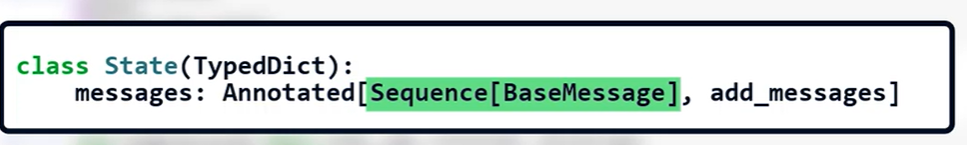

For that reason, Lang Graph offers a pre-implemented class with all these features. The class is called Messages state and can be imported from the Langgraf. graph module.

In [ ]:
from langgraph.graph import MessagesState


In [ ]:
#Remove the definition of the state class because it won't be needed anymore
# # Define the State
# class State(TypedDict):
#     messages: Annotated[Sequence[BaseMessage], add_messages]

The nodes `ask question`, `chatbot` and `ask another question` will accept a `messages state` object and output the same.

In [ ]:
def ask_question(state: MessagesState) -> MessagesState:

    print(f"\n-------> ENTERING ask_question:")
    for i in state["messages"]:
        i.pretty_print()

    question = "What is your question?"
    print(question)

    return MessagesState(messages = [AIMessage(question), HumanMessage(input())])

In [ ]:
def chatbot(state: MessagesState) -> MessagesState:

    print(f"\n-------> ENTERING chatbot:")
    for i in state["messages"]:
        i.pretty_print()

    response = chat.invoke(state["messages"])
    response.pretty_print()

    return MessagesState(messages = [response])

In [ ]:
def ask_another_question(state: MessagesState) -> MessagesState:

    print(f"\n-------> ENTERING ask_another_question:")
    for i in state["messages"]:
        i.pretty_print()

    question = "Would you like to ask one more question (yes/no)?"
    print(question)

    return MessagesState(messages = [AIMessage(question), HumanMessage(input())])

In [ ]:
#Define the Routing Function
def routing_function(state: MessagesState) -> Literal["ask_question", "__end__"]:

    if state["messages"][-1].content == "yes":
        return "ask_question"
    else:
        return "__end__"

In [ ]:
# Define the Graph
graph = StateGraph(MessagesState)

In [ ]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question",
                            path = routing_function)

In [ ]:
graph_compiled = graph.compile()

In [ ]:
graph_compiled

Invoke the compiled graph with an instance of the messages state class.

In [ ]:
#Test the Graph
graph_compiled.invoke(MessagesState(messages = []))

You can always create a custom class inheriting from messages state and include additional keys to the dictionary that do or don't have a reducer attached. It's all project dependent.

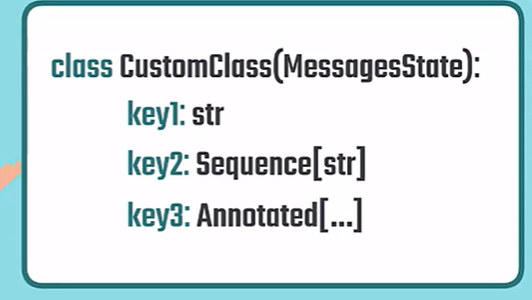

So, a pending messages to the state helped simulate chatbot memory, right? But such an approach is only feasible for very short interactions. Long running conversations would be too time and token consuming, because we'd feed the chatbot more information at each iteration. One alternative would be to trim our messages, feed only the last few messages to the next

# The RemoveMessages Class

Hey, throughout the last couple of lessons, we used the technique of appending messages to the graph state as a form of chatbot memory. While this is a valid approach for small scale applications, a long conversation would take too much time and use up too many tokens as we keep adding more information at each step. So, in this lesson, we'll implement a solution to reduce the number of messages sent to the chatbot node, a middle ground between sending just the last message and the entire conversation history.

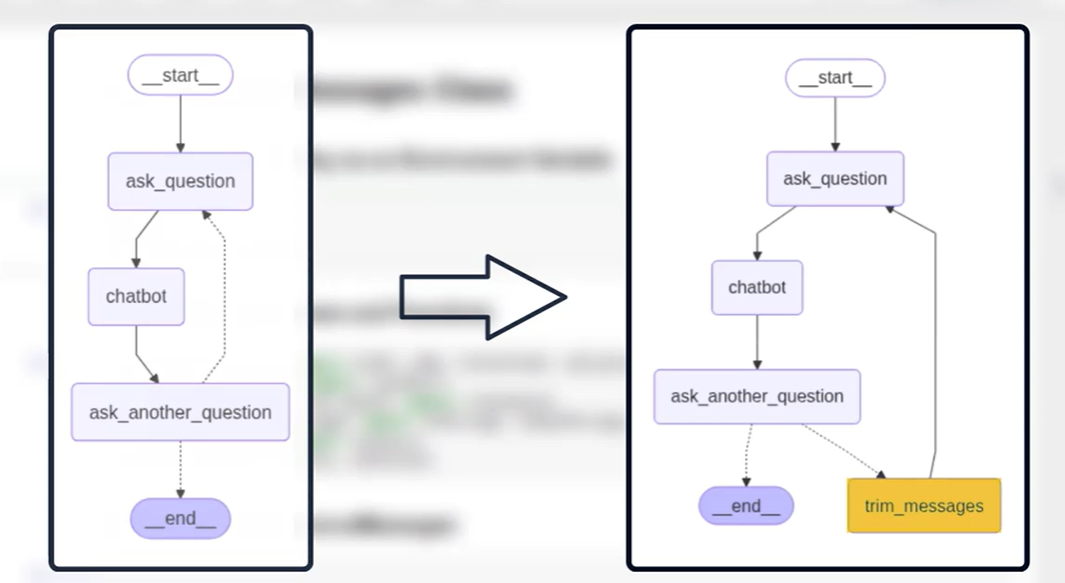

Consider the graph we previously implemented. Let's introduce one more note between ask another question and ask question. Call it trim messages. The node will be responsible for leaving only the final 5 messages in the list before moving on to the follow-up question.

For that, let's introduce the remove message class from the Langchaincore.messages module. This is a message responsible for deleting other messages.

In [ ]:
from langchain_core.messages import  RemoveMessage


For the following demonstration, I've prepared a list storing two loop iterations. We now want to remove all but the last 5 of them. Now, notice that I created the list using the add messages function.

In [ ]:
my_list = add_messages([AIMessage("What is your question?"),
                        HumanMessage("Could you tell me a grook by Piet Hein?"),
                        AIMessage("Certainly! Here's a well-known grook by Piet Hein..."),
                        AIMessage("Would you like to ask one more question?"),
                        HumanMessage("yes"),
                        AIMessage("What is your question?"),
                        HumanMessage("Where was the poet born?"),
                        AIMessage("Piet Hein was born in Copenhagen, Denmark, on December 16, 1905."),
                        AIMessage("Would you like to ask one more question?")],
                       [HumanMessage("yes")]
                      )

NameError: name 'add_messages' is not defined

In [ ]:
my_list[:-5]

NameError: name 'my_list' is not defined

We'll create a remove message object using the ID of the original message. Let's study the result. We have a list of 5 remove message objects, each keeping the ID of the corresponding original message. But how is this useful?

In [ ]:
remove_messages = [RemoveMessage(id = i.id) for i in my_list[:-5]]

NameError: name 'my_list' is not defined

In [ ]:
remove_messages

Let's call the add messages function with the original list and the list of removed messages. How interesting. We've deleted the first couple of messages and have kept only the last 5. This is extremely useful because this reducer function can elegantly append and remove messages at each step.

In [ ]:
add_messages(my_list, remove_messages)

# Trimming Messages

Make sure you've defined all the nodes. Insert a new cell and create a function called trim messages. Like all other nodes, this one also accepts a messages state object as an argument and outputs an object of the same type.

In [ ]:
def ask_question(state: MessagesState) -> MessagesState:

    print(f"\n-------> ENTERING ask_question:")
    for i in state["messages"]:
        i.pretty_print()

    question = "What is your question?"
    print(question)

    return MessagesState(messages = [AIMessage(question), HumanMessage(input())])

In [ ]:
def chatbot(state: MessagesState) -> MessagesState:

    print(f"\n-------> ENTERING chatbot:")
    for i in state["messages"]:
        i.pretty_print()

    response = chat.invoke(state["messages"])
    response.pretty_print()

    return MessagesState(messages = [response])

In [ ]:
def ask_another_question(state: MessagesState) -> MessagesState:

    print(f"\n-------> ENTERING ask_another_question:")
    for i in state["messages"]:
        i.pretty_print()

    question = "Would you like to ask one more question (yes/no)?"
    print(question)

    return MessagesState(messages = [AIMessage(question), HumanMessage(input())])

In [ ]:
def trim_messages(state: MessagesState) -> MessagesState:
    print(f"\n-------> ENTERING trim_messages:")

    remove_messages = [RemoveMessage(id = i.id) for i in state["messages"][:-5]] #Substitute my list with the value of the messages key from the state dictionary.

    return MessagesState(messages = remove_messages) #Return a messages state object and feed the remove messages list.
    #Recall that this list will be fed as an argument to the reducer function, which will ensure that the desired messages are removed

In [ ]:
#If the user decides to ask a follow-up question, the graph must route to the trim messages node, where only the last 5 messages are kept. If the user responds otherwise, the graph terminates.
def routing_function(state: MessagesState) -> Literal["trim_messages", "__end__"]:


    if state["messages"][-1].content == "yes":
        return "trim_messages"
    else:
        return "__end__"

In [ ]:
graph = StateGraph(MessagesState)

In [ ]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)
graph.add_node("trim_messages", trim_messages) #we add the trim messages node to the state graph.

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question",
                            path = routing_function)
graph.add_edge("trim_messages", "ask_question") #Additionally, we include one more edge pointing from trim messages to ask question.

In [ ]:
graph_compiled = graph.compile()

In [ ]:
graph_compiled

In [ ]:
graph_compiled.invoke(MessagesState(messages = []))

we demonstrated that this approach could be very convenient in cases where the subject of the conversation is frequently mentioned, so that the chatbot knows what you're referring to at any time. But there's always the concern that conversation details might be lost along the way, and the chatbot might respond inadequately. If this is an issue for your program, then the next technique might be for you, summarizing messages.

# Summarizing Messages

We'll now implement yet another more efficient approach for long running conversations. Instead of storing previous interactions verbatim, we'll summarize them. The game plan is as follows.
- **First**, we'll create a new graph state inheriting from the messages state class. It will have an additional parameter summary, where we'll store the conversation's running summary.
- **Second**, we'll modify the chatbot node to feed the user's question and the summary.
- **Finally**, we'll substitute the trim messages node with one that creates a new summary or extends an existing one. Once done, it deletes all messages in the state.

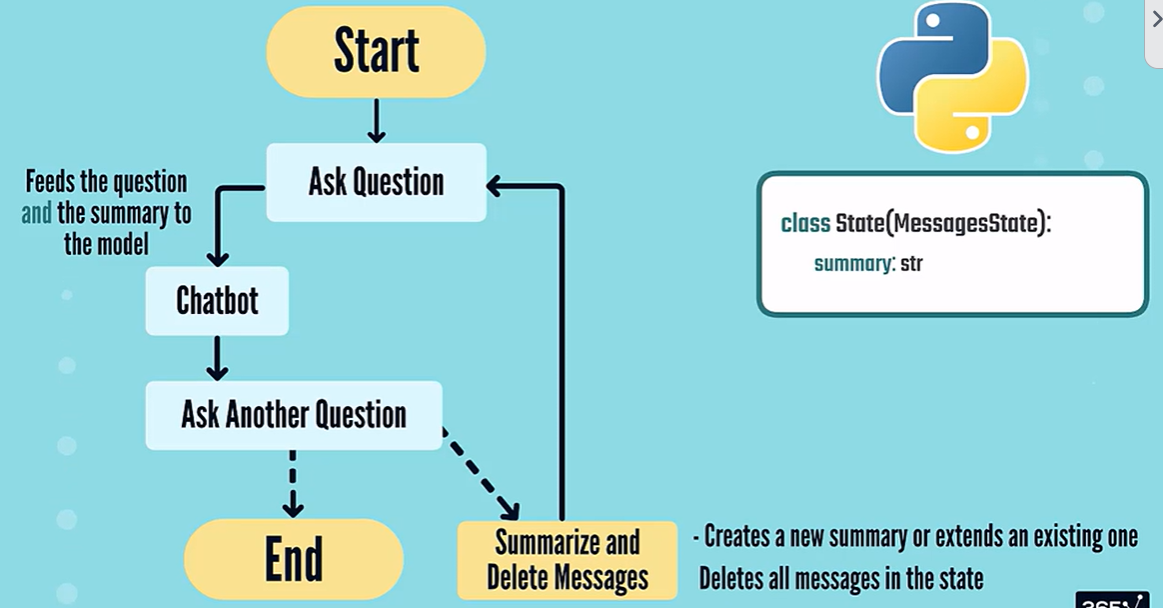

In [ ]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, RemoveMessage
from typing import Literal

In [ ]:
#Define the State
class State(MessagesState):
    summary: str

Notice that this key is not annotated with a reducer, unlike the messages key annotated with the add messages method. Therefore, with each update, the old value of the summary key will be replaced with a new one.

In [ ]:
test_state = State()

In [ ]:
#Notice that attempting to retrieve the value of the summary key will throw a key error since there is no pair with the desired key. But that would pose a problem later when we must check if a conversation summary exists. This is where the get method enters.
test_state["summary"]

the **get method** . It takes two positional arguments.
The first one is the key's name. The second one is the return value if such a pair doesn't yet exist. An empty string is a good choice because it returns false when converted to a boolean value, whereas a populated one would return true.

In [ ]:
bool(test_state.get("summary", ""))

In [ ]:
#Define the Nodes
chat = ChatOpenAI(model = "gpt-4o",
                  seed = 365,
                  temperature = 0,
                  max_completion_tokens = 100)

Next, I'll remove the pretty prints from the ask question node so they don't clutter the output. Type hint the function to accept and return an object of a state data type.

In [ ]:
def ask_question(state: State) -> State:

    print(f"\n-------> ENTERING ask_question:")

    question = "What is your question?"
    print(question)

    return State(messages = [AIMessage(question), HumanMessage(input())])

let's define an F string called System message that instructs the model as follows. Here's a quick summary of what's been discussed so far. Keep this in mind as you answer the next question. Within the curly braces, let's enter state.get. Include summary and an empty string as arguments. This will ensure we feed the model a summary or an empty string if none has yet been generated

In [ ]:
def chatbot(state: State) -> State:

    print(f"\n-------> ENTERING chatbot:")
    for i in state["messages"]:
        i.pretty_print()

    system_message = f'''
    Here's a quick summary of what's been discussed so far:
    {state.get("summary", "")}

    Keep this in mind as you answer the next question.
    '''

    response = chat.invoke([SystemMessage(system_message)] + state["messages"]) #invoke the model with a list containing a system message with the instructions above. Concatenate it with the messages list in the dictionary.
    response.pretty_print()

    return State(messages = [response])

In [ ]:
def ask_another_question(state: State) -> State:

    print(f"\n-------> ENTERING ask_another_question:")

    question = "Would you like to ask one more question (yes/no)?"
    print(question)

    return State(messages = [AIMessage(question), HumanMessage(input())])

In [ ]:
def summarize_and_delete_messages(state: State) -> State:
    print(f"\n-------> ENTERING trim_messages:")

    new_conversation = "" #stores the conversation so far in a readable form.
    for i in state["messages"]: #A simple for loop appends the message type AI or human and its content to the string.
        new_conversation += f"{i.type}: {i.content}\n\n"

     #Next, define a variable storing the following summary instructions inside an F string.
     #Update the ongoing summary by incorporating the new lines of conversation below.
     #We continue the instructions by providing the summary, if it exists, using state.get.
     #Define a variable summary to store the conversation's running summary as an AI message.
    summary_instructions = f'''
Update the ongoing summary by incorporating the new lines of conversation below.
Build upon the previous summary rather than repeating it so that the result
reflects the most recent context and developments.


Previous Summary:
{state.get("summary", "")}

New Conversation:
{new_conversation}
'''

    print(summary_instructions)

    summary = chat.invoke([HumanMessage(summary_instructions)]) #Pass the instructions as a human message.

    remove_messages = [RemoveMessage(id = i.id) for i in state["messages"][:]] #modify the remove messages variable, so all messages in the state are deleted.

    #Return a state object with the first parameter set to remove messages as before. The second one, summary, will store the content from the model's response.
    return State(messages = remove_messages, summary = summary.content)

In [ ]:
#  Define the Routing Function
def routing_function(state: State) -> Literal["summarize_and_delete_messages", "__end__"]:

    if state["messages"][-1].content == "yes":
        return "summarize_and_delete_messages"
    else:
        return "__end__"

In [ ]:
# Define the Graph
graph = StateGraph(State)

In [ ]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)
graph.add_node("summarize_and_delete_messages", summarize_and_delete_messages)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question",
                            path = routing_function)
graph.add_edge("summarize_and_delete_messages", "ask_question")

In [ ]:
graph_compiled = graph.compile()

In [ ]:
graph_compiled

In [ ]:
#Test the Graph
graph_compiled.invoke(State(messages = []))

We've made great progress. We've started integrating memory into our chatbot, an exciting step forward. However, there's an important detail to consider. Note that the memory we've implemented so far only persists during the current execution. In other words, if you rerun the graph, it won't remember anything from the previous conversation. The memory resets with each new invocation. Give it a try, rerun the compiled graph, and watch the memory start fresh. This is where thread level persistence comes in, retaining memory across multiple executions within the same conversation thread.

# Thread-Level Presistence

we'll learn how to persist conversations, that is how our graph can retain its memory even after restarting the notebook's kernel or shutting down the entire system. In Lagraph, this is made possible through a checkpointing system.

Recall the structure of a graph, a collection of nodes connected by direct or conditional edges. Nodes on different horizontal levels are executed sequentially, from top to bottom. Of course, we can loop back to an earlier node using a conditional edge. Nodes on the same horizontal level are executed in parallel, with some nodes activating and others remaining inactive depending on conditions. Each such horizontal level forms what is called a super step

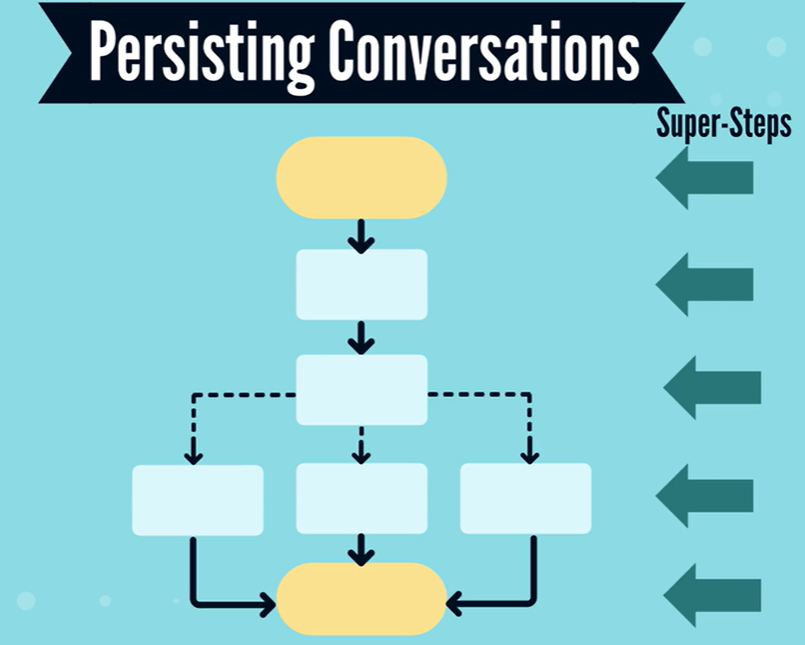

Now, let's return to memory. A checkpointer in line graph is a component that saves the state of the graph after each node execution within a super step. The saved information and additional metadata are stored in a line graph object called a state snapshot. These state snapshots open up exciting possibilities. For example, they enable human in the loop workflows. A human can inspect or modify the state mid-execution. This can be useful for testing, debugging, or even manually directing an agent. It makes working with chatbots far more transparent. No more treating them like mysterious black boxes.

We can now observe the model's decision-making process, which is particularly valuable when building agents are expected to reason or act autonomously.


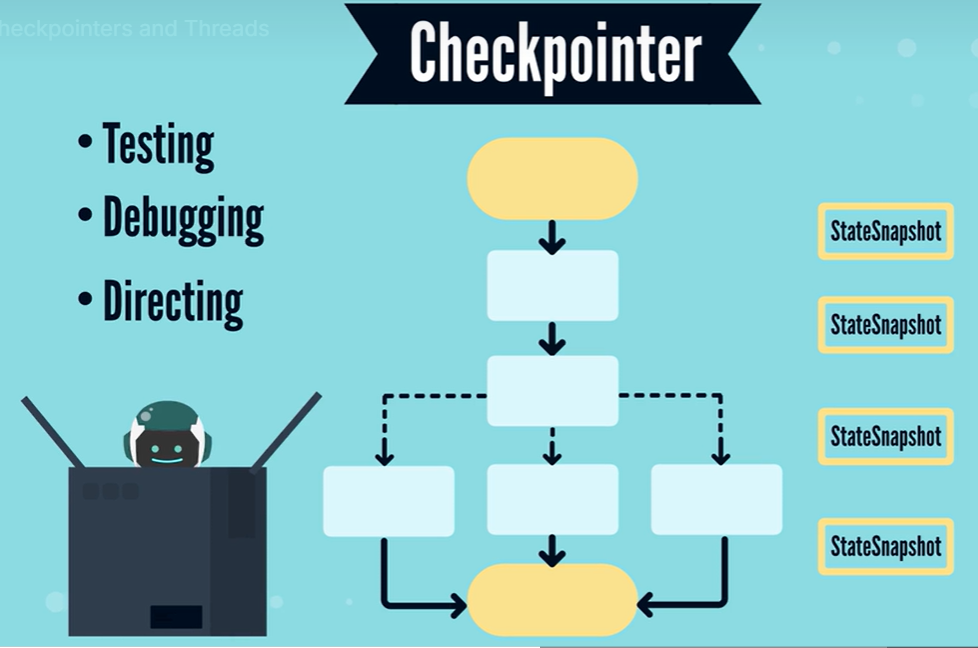

Next, let's talk about threads. A thread is simply a collection of related checkpoints. Each thread is identified by a thread ID which allows Landgraf to track the progression of different conversations. If a graph is invoked with a thread ID corresponding to a previous conversation, then the last checkpoint from that thread becomes the input state for the next run. In other words, threads provide continuity. They're how we give our conversational agents memory over time.

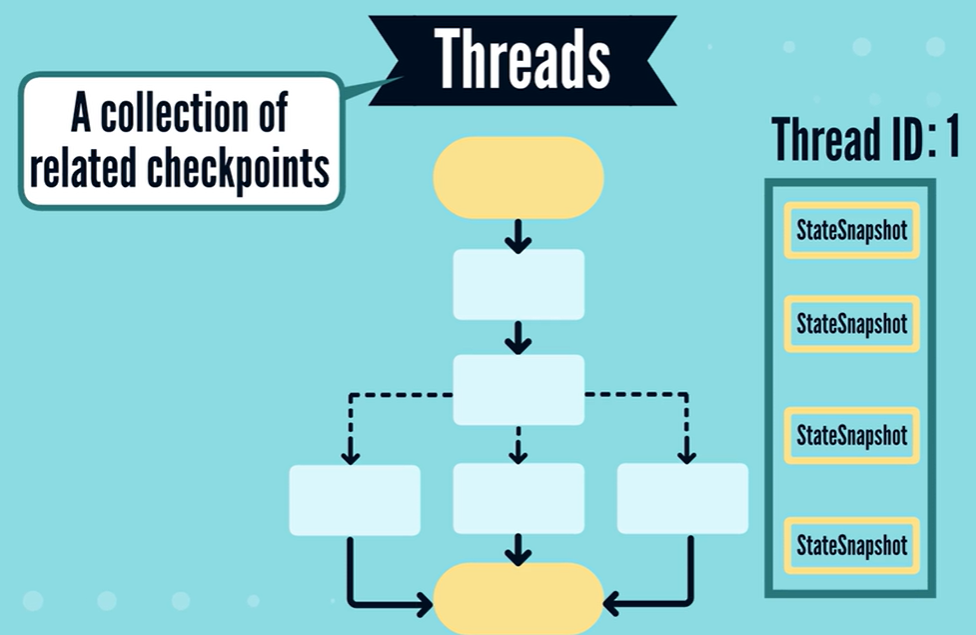

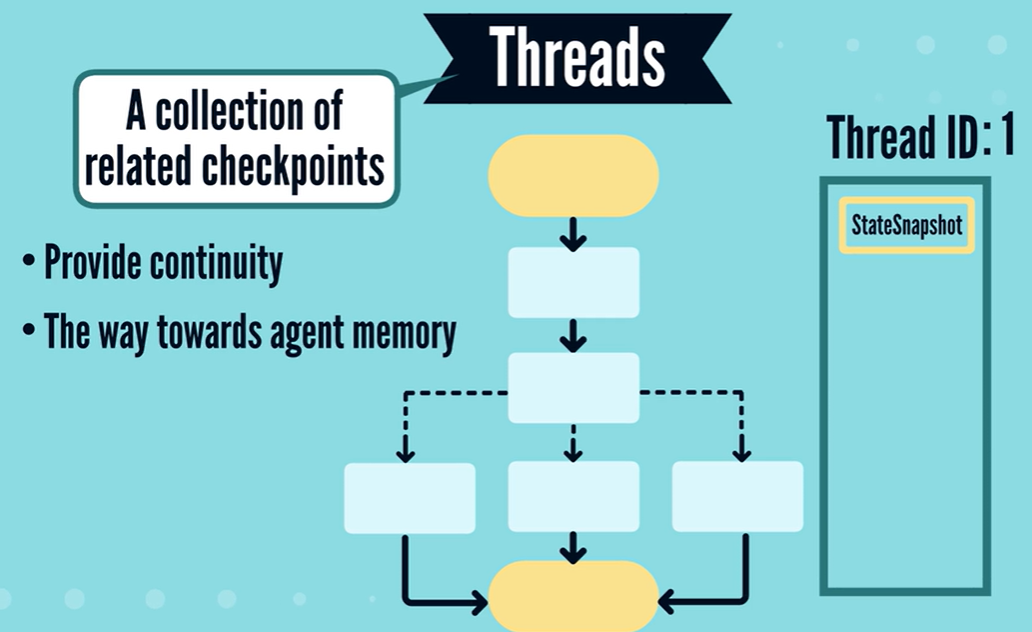

In this section, we'll explore two types of memory,
- **Short term memory,** called `thread scoped memory`, remembers interactions within a single thread. This memory, however, is volatile. It resets when the notebook kernel is restarted, or the system is shut down unless explicitly persisted.
- In contrast, **long-term memory** persists beyond the lifetime of a single session. This type of memory is typically backed by external storage, such as a vector database or a document store. Instead of holding data in memory alone, long-term memory allows the graph to retrieve relevant past information dynamically based on the context of a new input. This enables intelligent, context aware conversations that span days, weeks, or even years.

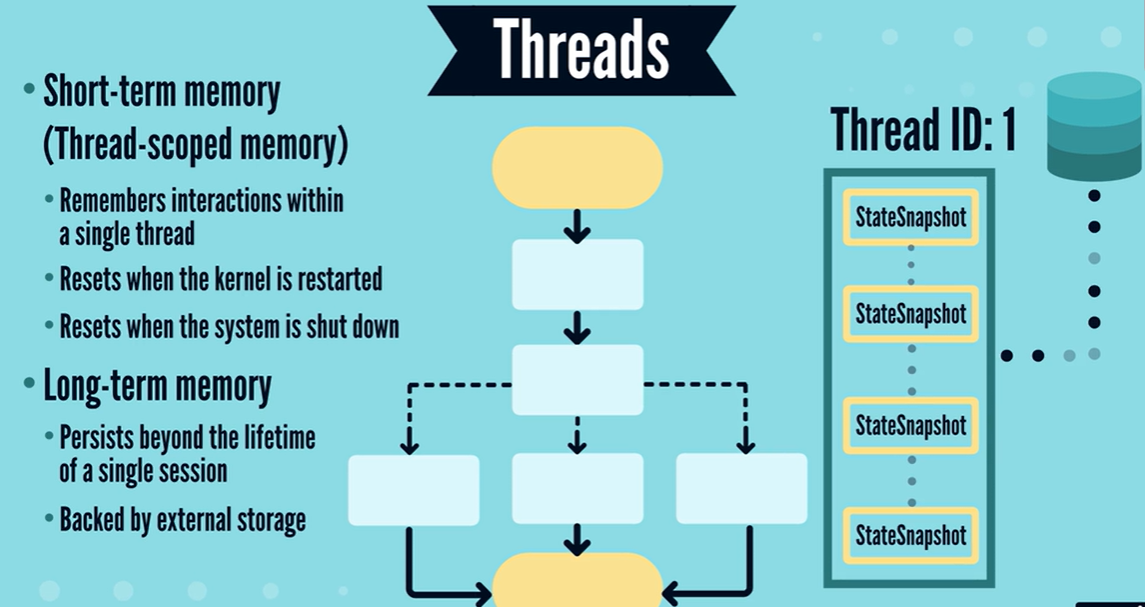

1. Long-Term Memory: Persistent memory stored across sessions or threads
1. Thread-Scoped Memory:  Memory limited to and shared within one thread
1. Thread ID:  Unique identifier for a specific thread
1.  Thread: A single conversation or workflow instance
1. State Snapshot:  A saved copy of a thread's full execution state
1. Checkpointer:  Saves and restores graph state during execution




#  Short-Term Memory with the InMemorySaver Class

In [ ]:
from langgraph.checkpoint.memory import InMemorySaver
# As the name implies, this class allows us to add in memory checkpointing to our graph, enabling it to save and restore state during execution.

In [ ]:
#defined a new class, a subclass of messages state that includes a key for storing the conversation's running summary.
class State(MessagesState):
    summary: str

defined the usual chat variable, an instance of the chat open AI class. The following 3 cells define the graphs nodes. The ask question note prompts the user to state their question. This string and the user's input are stored in the graph state as AI and human messages respectively.

The chatbot node takes the user's question with a running summary to provide a context aware response.

The summarization node instructs the GPT model to update the current summary using the new lines of conversation provided. After that, all messages in the state are removed.

 Finally, we build the graph by creating an instance of the state graph class. We add the 3 nodes and then connect them with the start and end nodes to create the desired graph

In [ ]:
chat = ChatOpenAI(model = "gpt-4o",
                  seed = 365,
                  temperature = 0,
                  max_completion_tokens = 100)

In [ ]:
def ask_question(state: State) -> State:

    print(f"\n-------> ENTERING ask_question:")

    question = "What is your question?"
    print(question)

    return State(messages = [AIMessage(question), HumanMessage(input())])

In [ ]:
def chatbot(state: State) -> State:

    print(f"\n-------> ENTERING chatbot:")

    system_message = f'''
    Here's a quick summary of what's been discussed so far:
    {state.get("summary", "")}

    Keep this in mind as you answer the next question.
    '''

    response = chat.invoke([SystemMessage(system_message)] + state["messages"])
    response.pretty_print()

    return State(messages = [response])

In [ ]:
def summarize_messages(state: State) -> State:
    print(f"\n-------> ENTERING summarize_messages:")

    new_conversation = ""
    for i in state["messages"]:
        new_conversation += f"{i.type}: {i.content}\n\n"

    summary_instructions = f'''
Update the ongoing summary by incorporating the new lines of conversation below.
Build upon the previous summary rather than repeating it,
so that the result reflects the most recent context and developments.
Respond only with the summary.

Previous Summary:
{state.get("summary", "")}

New Conversation:
{new_conversation}
'''

    print(summary_instructions)

    summary = chat.invoke([HumanMessage(summary_instructions)])

    remove_messages = [RemoveMessage(id = i.id) for i in state["messages"][:]]

    return State(messages = remove_messages, summary = summary.content)

In [ ]:
#Define the Graph
graph = StateGraph(State)

In [ ]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("summarize_messages", summarize_messages)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "summarize_messages")
graph.add_edge("summarize_messages", END)

- Start by creating an instance of the In Memory Saver class, which I'll call Checkpointer. This will act as the graph's short-term memory, allowing it to store checkpoints in memory during execution.

- Next, define the graph compiled variable as graph.comile, but this time pass checkpointer as an argument to the function.

In [ ]:
checkpointer = InMemorySaver()
graph_compiled = graph.compile(checkpointer)

In [ ]:
graph_compiled

Now that we've set up the checkpointing mechanism, we need to define a threat to group and persist those checkpoints. Start by creating a dictionary. Let's call it config one, and adding a key value pair with the key configurable. The value should be another dictionary, where the key is thread ID and the value is the thread identifier. You can choose any identifier. I'll use one.

In [ ]:
config1 = {"configurable": {"thread_id": "1"}}
config2 = {"configurable": {"thread_id": "2"}}

In [ ]:
# This instructs the graph to create in memory checkpoints and associate them with the specific thread, enabling thread level persistence.
graph_compiled.invoke(State(), config1)


The function returns an updated dictionary, an empty list of messages, and a summary of these messages

So let's create a second configuration with a thread ID equal to 2. Change the second argument of the invoke method accordingly and run the cell. Let's ask, when was the poet born? The chatbot is now confused. We must specify the poet we refer to. This second thread is responsible for an entirely new conversatio

In [ ]:
graph_compiled.invoke(State(), config2)

# The StateSnapshot Class

Let's study what these checkpoints look like in more detail.

In [ ]:
# "get_state_history" will retrieve the entire conversation history. The method accepts the configuration dictionary as an argument.
# graph_states =  graph_compiled.get_state_history(config1)

#let's redefine graph states as a list of states. For that, w'll apply list comprehension
graph_states = [i for i in graph_compiled.get_state_history(config1)]


In [ ]:
graph_states

set up a for loop that loops through each item in the list and simply prints it out. This will help us get a general idea of the object's appearance. We see the items in the list are instances of the state snapshot class and contain a lot of information, the messages, the summary, the thread and checkpoint IDs, the next graph to execute, and so on.

In [ ]:
for i in graph_states[]:
    print(i)

Keep in mind that the first item on the list is the last snapshot taken. So let's apply a couple of changes to the loop. For each state, let's include the messages list. The summary The next node to execute. And the step number.

In [ ]:
for i in graph_states[::-1]:
    print(f'''
Messages: {i.values["messages"]}
Summary: {i.values.get("summary", "")}
Next: {i.next}
Step: {i.metadata["step"]}''')

- The first snapshot corresponds to the state we feed to the graph, an empty messages list with no summary.

- The step number is -1, meaning that we are yet to enter the graph.

- The start node doesn't modify the state, so the next snapshot looks the same.This is where the snapshot count begins, of course, starting from 0.



Following that, we have a populated list of messages, one AI and one human message.

- Exiting the chatbot node at step 2, we have the response from the model appended to the messages.
- The following note is responsible for generating the summary and deleting all messages.
- We exit the graph in the next step.
- From step 4 onwards, everything repeats. And this is how checkpoints in Landgraf work.

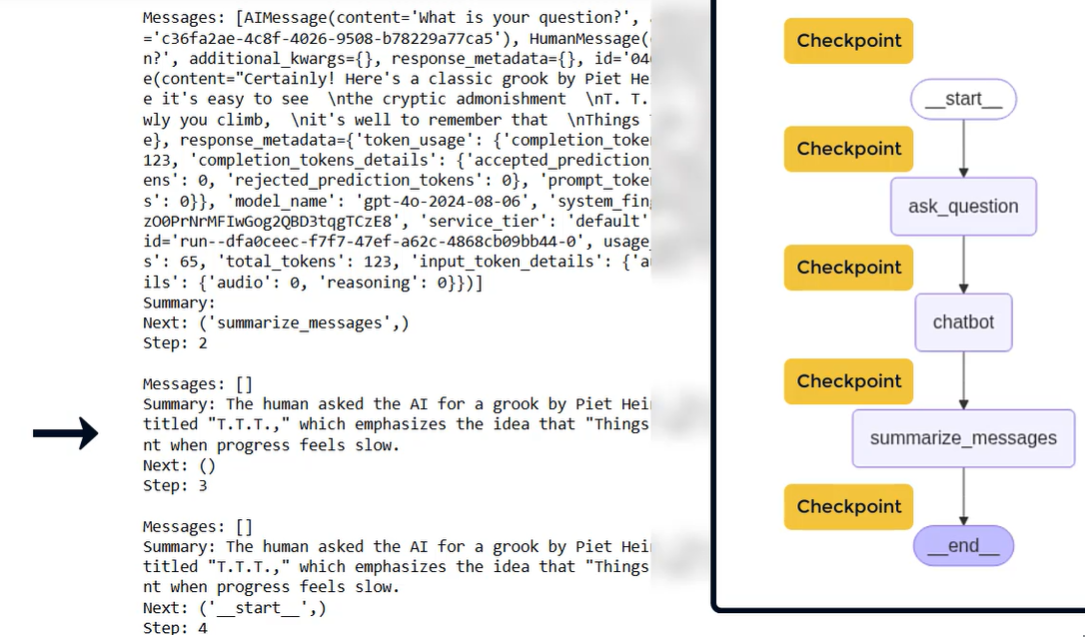

# Long-Term Memory with SQLite

In the previous session, we made significant progress by persisting the conversation summary to a thread. This allowed us to re-invoke the graph and continue the discussion within the same thread. But the in memory saver class we used had a key limitation. Restarting the notebook's kernel resulted in memory loss.

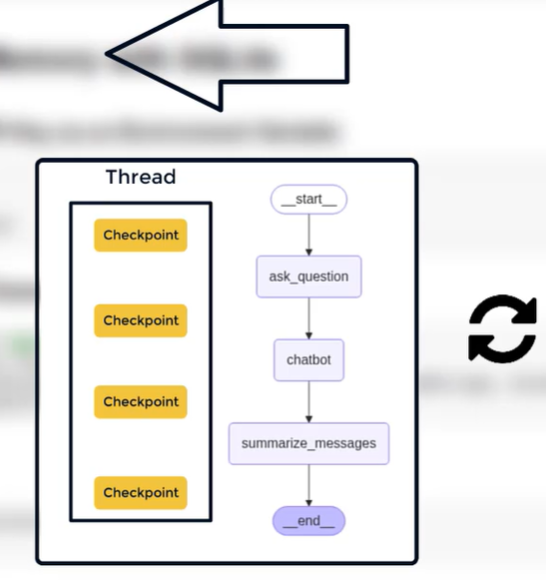

We'll wrap up our discussion on memory by learning how to store checkpoints in a local database. This approach enables us to restore the graphs state even after a kernel restart. We'll use SQL Light, a lightweight disk-based database ideal for prototyping. For production grade applications, you typically opt for a more robust and scalable solution such as Postress QL or Redis

In [ ]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage, RemoveMessage
from langgraph.checkpoint.memory import InMemorySaver
import sqlite3  #allow us to create and connect to a local SQL Light database.
from langgraph.checkpoint.sqlite import SqliteSaver # act as the counterpart to the in memory saver class we used in the previous

In [ ]:
class State(MessagesState):
    summary: str

In [ ]:
chat = ChatOpenAI(model = "gpt-4o",
                  seed = 365,
                  temperature = 0,
                  max_completion_tokens = 100)

In [ ]:
def ask_question(state: State) -> State:

    print(f"\n-------> ENTERING ask_question:")

    question = "What is your question?"
    print(question)

    return State(messages = [AIMessage(question), HumanMessage(input())])

In [ ]:
def chatbot(state: State) -> State:

    print(f"\n-------> ENTERING chatbot:")

    system_message = f'''
    Here's a quick summary of what's been discussed so far:
    {state.get("summary", "")}

    Keep this in mind as you answer the next question.
    '''

    response = chat.invoke([SystemMessage(system_message)] + state["messages"])
    response.pretty_print()

    return State(messages = [response])

In [ ]:
def summarize_messages(state: State) -> State:
    print(f"\n-------> ENTERING summarize_messages:")

    new_conversation = ""
    for i in state["messages"]:
        new_conversation += f"{i.type}: {i.content}\n\n"

    summary_instructions = f'''
Update the ongoing summary by incorporating the new lines of conversation below.
Build upon the previous summary rather than repeating it,
so that the result reflects the most recent context and developments.
Respond only with the summary.

Previous Summary:
{state.get("summary", "")}

New Conversation:
{new_conversation}
'''

    print(summary_instructions)

    summary = chat.invoke([HumanMessage(summary_instructions)])

    remove_messages = [RemoveMessage(id = i.id) for i in state["messages"][:]]

    return State(messages = remove_messages, summary = summary.content)

In [ ]:
#Define the Graph
graph = StateGraph(State)

In [ ]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("summarize_messages", summarize_messages)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "summarize_messages")
graph.add_edge("summarize_messages", END)

In [ ]:
# set up an SQL light-backed database for persistence.
#We must also specify the name of the database and end with .db. If the file doesn't yet exist, as in our case, it will create one implicitly.
db_path = "C:/Users/Hristina/Desktop/LangGraph_DB/langgraph.db"
#set up a connection using SQL Light's connect method. One of its parameters, database, accepts the string that specifies the path to your database file. Another important parameter is check same thread. In our case, we won't need to worry too much about it. For now, it's sufficient to know that setting the perimeter to false allows the same SQL light connection object to be accessed from multiple threads, which can be helpful in specific contexts.
con = sqlite3.connect(database = db_path, check_same_thread = False)

In [ ]:
#set up the checkpointer variable as an instance of Langgraf's SQL light saver class. Then pass the SQL light connection as an argument.
checkpointer = SqliteSaver(con)

In [ ]:
graph_compiled = graph.compile(checkpointer)

In [ ]:
graph_compiled

In [ ]:
config1 = {"configurable": {"thread_id": "1"}}

In [ ]:
graph_compiled.invoke(State(), config1)

Invoke the compiled dictionary with an instance of the state class and the dictionary. Let's ask something different. Who is the creator of the Python language? We get an answer. You can also check that the summary in the state is updated accordingly. Now, go to the kernel menu at the top of the notebook, select Restart kernel, and approve the operation. This will clear all variables from memory and reset the execution environment. Return to the beginning and start running the cells in order. Notice that we're now making a connection to an existing database. Run the rest of the cells until you invoke the graph. Let's ask, where was he born? Excellent. The graph successfully retrieves information from the local database because the chatbot responds appropriately to our question.

#Conclusion

- After we set up our environment, we became familiar with the construction of a graph, how to define states, nodes, and edges, and then how to combine them to create a functioning graph. We also complicated the graph to include a conditional edge that could route the logic to one of two nodes.
- In the following section, we became familiar with an interesting typing construct, the `annotated class`. It was beneficial for adding metadata to our variables and more specifically, reducer functions.
- The `add_messages` reducer function allowed us to resolve a pesty issue. Incoming conversation messages replaced old ones with each state update. The function helped us append them instead. But this introduced new challenges. The conversation became too lengthy, causing our chatbot to consume excessive resources.
- To address this, we implemented a method to `trim messages` once they exceeded a certain threshold. Well, that was an easy solution for small scale applications, context dependent conversations were an issue.
- We then came up with another solution, `summarizing` them. This took the best of both worlds. It kept the context from earlier in the conversation and wasn't as token intensive.

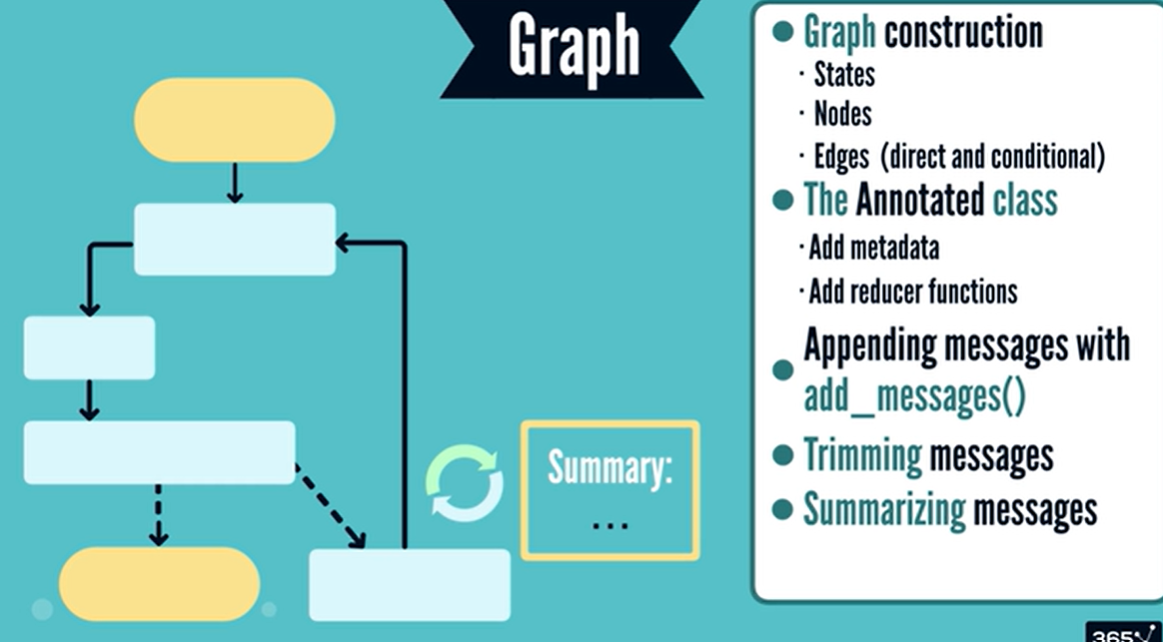

- Soon after, we hit another wall. The summary was deleted once we re-invoked the graph. This posed a significant issue that led us to the following topic, `thread level persistence`. We introduced `checkpoints`, which represents snapshots of the graphs stayed at each supers step. A thread, in turn, was a collection of such checkpoints. We modified our implementation to equip the graph with short-term memory, storing the checkpoints in memory.

- While this could be a good solution for some applications, it poses a problem for more sophisticated ones. This led us to the final lesson of our practical part, implementing long-term memory. We relied on an external database where the checkpoints are stored. Therefore, re-invoking the graph, restarting the kernel, or even restarting the entire system didn't wipe the memory out but could be retrieved when needed.

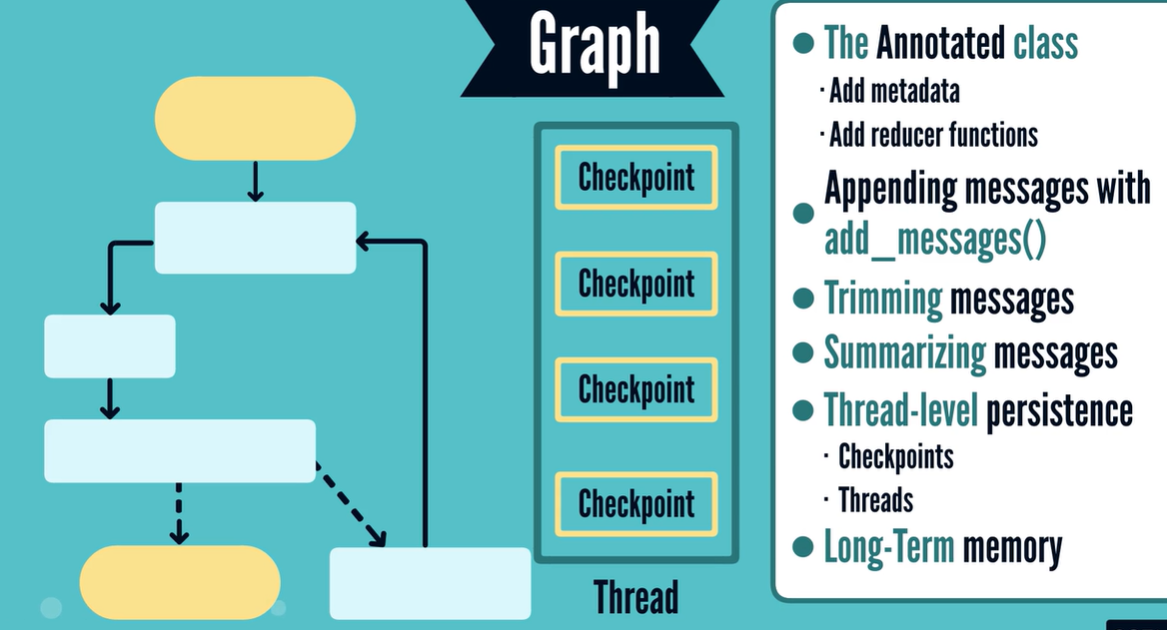